In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # put -1 to not use any

In [6]:
import math
import pandas as pd
import numpy as np 
import seaborn as sns

import torch
from scipy import ndimage
import seaborn as sns
import matplotlib.pyplot as plt
import SimpleITK as sitk

from sklearn.metrics import classification_report, confusion_matrix
from evaluation import plot_confusion_matrix
import cv2
# from predict_outcome_height_analysis import 

# Functions

In [47]:
def read_data(dataframe, mount_point):
  # read output generated by process_heights script
  # faster to read processed heights instead of creating them everytime

  list_class = []
  list_files = []
  list_heights = []
  list_x = []
  for idx, row in dataframe.iterrows():
    seg_path = os.path.join(mount_point, row['seg'])
    npy = seg_path.replace('seg', 'segmentation_heights_v2').replace('.nrrd', '.npy')
    if os.path.exists(npy):
      data = np.load(npy,allow_pickle=True).item()
      x_values = data['x_bottom']
      heights = data['heights']

      valid_indices = ~np.isnan(heights)
      heights = heights[valid_indices]
      x_values = x_values[valid_indices]

      xmin = np.min(x_values)
      xmax = np.max(x_values)

      new_x = np.linspace(xmin, xmax, num=400)
      new_y = np.interp(new_x, x_values, heights)
      list_heights.append(new_y)
      list_x.append(new_x)

      list_class.append(row['class'])
      list_files.append(npy)

  all_heights = np.stack(list_heights, axis=0)
  all_x = np.stack(list_x, axis=0)
  all_classes = np.array(list_class)

  return all_heights, all_x, all_classes, list_files

def compute_eye_bbx(seg, label=1, pad=0.01):

  shape = seg.shape
  
  ij = torch.argwhere(seg.squeeze() != 0)

  bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

  bb[0] = torch.clip(torch.min(ij[:,1]) - shape[1]*pad, 0, shape[1])
  bb[1] = torch.clip(torch.min(ij[:,0]) - shape[0]*pad, 0, shape[0])
  bb[2] = torch.clip(torch.max(ij[:,1]) + shape[1]*pad, 0, shape[1])
  bb[3] = torch.clip(torch.max(ij[:,0]) + shape[0]*pad, 0, shape[0])
  
  return bb

def get_outcome(outcome, val):
  outcome.append(val)
  return outcome

def separate_good_from_bad(outcome):
  dic_outcome = {'entropion':[], 'overcorrection':[]}
  locations = []
  for elt in outcome :
    elts = elt.split(' ')
    if 'entropion' in elts[0]:
      dic_outcome[elts[0]].append(elts[1])
      locations.append(elts[1])
    elif 'overcorrection' in elts[0]:
      dic_outcome[elts[0]].append(elts[1])
      locations.append(elts[1])

  new_dict = {k: list(np.unique(v)) for k, v in dic_outcome.items() if v} 

  return new_dict, np.unique(locations)

def find_wavy_eyelid(smooth_ratio,outcome):
  gradient = np.gradient(smooth_ratio)
  gradient = gradient[30:-30]
  abs_grad = np.abs(gradient)
  thr = np.mean(abs_grad) + 2*np.std(abs_grad)
  if thr > 0.0010:

    peaks = abs_grad > np.mean(abs_grad)+ 2*np.std(abs_grad)
    original_idx_peaks = np.where(peaks)[0]
    idx_peaks_to_keep = np.where(np.diff(original_idx_peaks) > 1)
    if len(original_idx_peaks) > 0:
      global_localization = original_idx_peaks[idx_peaks_to_keep].tolist()
      global_localization.append(original_idx_peaks[-1])
      num_peaks = len(global_localization)      
      if num_peaks == 2:
        if thr > 0.0017:
          return "Yes"
        else:
          return "Maybe"

      elif num_peaks >=2:
        return "Yes"
      else:
        return 'No'

def find_locations(dict_outcome):
    all_keys=list(dict_outcome.keys())
    if len(all_keys) == 1:
      # one outcome
      vals = dict_outcome[all_keys[0]]
      if 'G' in vals: vals.remove('G')
      locations = {all_keys[0]: vals}
      
    else:

      vals = list(dict_outcome.values())
      list1, list2 = vals[0], vals[1]
      if 'G' in list1: list1.remove('G')
      if 'G' in list2: list2.remove('G')

      overlap = set(list1) & set(list2)
      if overlap:
        for val in overlap:
          while val in list1:
              list1.remove(val)
          while val in list2:
            list2.remove(val)
        locations = {k: list(np.unique(v)) for k, v in dict_outcome.items() if v} 
        return locations
      else:
        locations =  {all_keys[0]:list1, all_keys[1]:list2 }
    return locations


In [48]:
def global_curve_analysis(ratio, outcome, cpt_count):

  global_mean = np.mean(ratio) ## second labels

  if global_mean < 0.09:
    outcome = get_outcome(outcome, 'entropion G') 
    # print('entropion G', global_mean)
    cpt_count.append(1)
  elif global_mean > 0.125:
    outcome = get_outcome(outcome, 'overcorrection G')
    cpt_count.append(-1)
  else:
    cpt_count.append(0)
    outcome = get_outcome(outcome, 'Healthy')
  
  return outcome, cpt_count

In [49]:
def middle_side_analysis(ratio, outcome, cpt_count):
  # comparing height between left and right of middle section -> it should be similar.

  val_left = ratio[100:150]
  val_right = ratio[250:300]
  # print("Sides Mean ", np.mean(val_left), np.mean(val_right))
  if  np.mean(val_left) < 0.10:
    outcome = get_outcome(outcome, 'entropion L')
    cpt_count.append(1)
    # print(outcome)


  elif np.mean(val_left) > 0.15:
    outcome = get_outcome(outcome, 'overcorrection L')
    cpt_count.append(-1)

  elif  np.mean(val_right) < 0.10:
    outcome = get_outcome(outcome, 'entropion R')
    cpt_count.append(1)
    # print(outcome)


  elif np.mean(val_right) > 0.15:
    outcome = get_outcome(outcome, 'overcorrection R')
    cpt_count.append(-1)

  if (0.12 < np.mean(val_left) < 0.14): 
    if np.mean(val_right) < 0.10:
      # if right to low it's undercorrected
      outcome = get_outcome(outcome, 'entropion R')
      cpt_count.append(1)
      # print(outcome)
    elif np.mean(val_right) > 0.14:
      # if right to high it's overcorrected
      outcome = get_outcome(outcome, 'overcorrection R')
      cpt_count.append(-1)

    else:
      cpt_count.append(0)
      outcome = get_outcome(outcome, 'Healthy')

      
  # if the right has an appropriate correction
  elif (0.12 < np.mean(val_right) < 0.14): 
    if np.mean(val_left) < 0.10:
      # if right to low it's undercorrected
      outcome = get_outcome(outcome, 'entropion L')
      cpt_count.append(1)
      # print(outcome)

    elif np.mean(val_left) > 0.14:
      # if right to high it's overcorrected
      outcome = get_outcome(outcome, 'overcorrection L')
      cpt_count.append(-1)

    else:
      cpt_count.append(0)
      outcome = get_outcome(outcome, 'Healthy')


  else:
    cpt_count.append(0)
  # print()
  # print()

  return outcome, cpt_count

In [50]:
def mean_analysis(mean_df, outcome, cpt_count):
  
  mean_left = mean_df.iloc[0]['mean']
  mean_middle = mean_df.iloc[1]['mean']
  mean_right =  mean_df.iloc[2]['mean']
  len_cpt = len(cpt_count)

  # print("Mean ", mean_left, mean_middle, mean_right)

  if ( mean_middle < mean_left) or (mean_middle < mean_right):
    if mean_middle > 0.11:
      cpt_count.append(-1)
      if mean_middle < mean_left:
        outcome = get_outcome(outcome, 'overcorrection L')
      if mean_middle < mean_right:
        outcome = get_outcome(outcome, 'overcorrection R')
    else:
      ### if the sides mean are higher than the middle correction --> the middle section is probably undercorrected
      outcome = get_outcome(outcome, 'entropion M')
      cpt_count.append(1)
      # print(outcome)


  ## Here we're checking in more details the height differences between the middle and the side section.
  diff_left =  np.abs(mean_left-mean_middle) / mean_middle
  diff_right =  np.abs(mean_right-mean_middle) / mean_middle

  # if similar correction for middle and side
  if diff_left <= 0.1 and diff_right <= 0.1:
    if mean_middle > 0.12:
      outcome = get_outcome(outcome, 'overcorrection R')
      outcome = get_outcome(outcome, 'overcorrection L')
      cpt_count.append(-1)

    elif mean_middle < 0.12:
      outcome = get_outcome(outcome, 'entropion M')
      cpt_count.append(1)
      # print(outcome)

  if diff_left < 0.1 and diff_right > 0.3:
    outcome = get_outcome(outcome, "overcorrection L")
    cpt_count.append(-1)

  elif diff_right < 0.1 and diff_left > 0.3:
    outcome = get_outcome(outcome, "overcorrection R")
    cpt_count.append(-1)

  if diff_left > 0.40:
    if mean_left < 0.06:
      outcome = get_outcome(outcome, 'entropion L')
      # print(outcome)
      cpt_count.append(1)

    if mean_middle > 0.12:
      outcome = get_outcome(outcome, 'overcorrection M')
      cpt_count.append(-1)

  elif diff_right > 0.40:
    if mean_right < 0.06:
      outcome = get_outcome(outcome, 'entropion R')
      # print(outcome)
      cpt_count.append(1)

    if mean_middle > 0.12:
      outcome = get_outcome(outcome, 'overcorrection M')

      cpt_count.append(-1)

  if len_cpt == len(cpt_count):
    cpt_count.append(0)

  # print()
  # print()


  return outcome, cpt_count

In [51]:
def max_analysis(dataframe, outcome, cpt_count):
  maxs = dataframe['max'].tolist()
  # print("Mean ", maxs)

  if maxs[0] > 0.14:
    outcome = get_outcome(outcome, 'overcorrection L')
    cpt_count.append(-1)

  if maxs[1] > 0.15  :
    outcome = get_outcome(outcome, 'overcorrection M')
    cpt_count.append(-1)

  if maxs[2] > 0.14:
    outcome = get_outcome(outcome, 'overcorrection R')
    cpt_count.append(-1)
  
  if 0.12 <  maxs[0] < 13 and 0.12 <  maxs[1] < 13 and 0.12  < maxs[2] < 13:
    cpt_count.append(0)


  if maxs[0] < 0.10:
    outcome = get_outcome(outcome, 'entropion L')
    cpt_count.append(1)
    # print(outcome)

  if maxs[1] < 0.11  :
    outcome = get_outcome(outcome, 'entropion M')
    cpt_count.append(1)
    # print(outcome)

  if maxs[2] < 0.10:
    outcome = get_outcome(outcome, 'entropion R')
    cpt_count.append(1)
    # print(outcome)


  # print()
  # print()

  return outcome, cpt_count

In [52]:
def plot_section_on_images(locations, segmentation_mask, image_to_display):

  dict_color_keys = {'entropion': 'bx', 'overcorrection':'rx',}

  h,w = segmentation_mask.shape
  portion_side = int(w/4)

  mask255 = (segmentation_mask.numpy() * 255).astype(np.uint8)

  contours, _ = cv2.findContours(mask255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cnt = max(contours, key=cv2.contourArea).squeeze()
  plt.imshow(image_to_display)
  plt.plot(cnt[:,0], cnt[:,1], 'gx')

  if locations != 'N/A':

    for k in list(locations.keys()):
      sections = locations[k]
      color_key = dict_color_keys[k]
      for s in sections:

        if s == 'L':
          mask255 = (segmentation_mask.numpy() * 255).astype(np.uint8)
          mask255[:, portion_side:] = 0

          contours, _ = cv2.findContours(mask255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          cnt = max(contours, key=cv2.contourArea).squeeze()
          plt.plot(cnt[:,0], cnt[:,1], color_key)
            
        elif s == 'M':
          mask255 = (segmentation_mask.numpy() * 255).astype(np.uint8)
          mask255[:, :portion_side] = 0
          mask255[:, -portion_side:] = 0


          contours, _ = cv2.findContours(mask255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          cnt = max(contours, key=cv2.contourArea).squeeze()
          plt.plot(cnt[:,0], cnt[:,1], color_key)
            
        elif s == 'R':
          mask255 = (segmentation_mask.numpy() * 255).astype(np.uint8)
          mask255[:, :-portion_side] = 0

          contours, _ = cv2.findContours(mask255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
          cnt = max(contours, key=cv2.contourArea).squeeze()
          plt.plot(cnt[:,0], cnt[:,1], color_key)


In [53]:
def adjust_classes_probabilities_based(cpt_count):
  mean_count =  np.mean(cpt_count)
  p = np.abs(mean_count)

  argmax = np.argmax(cpt_count)
  class_adjusted = 0

  # print(mean_count, argmax)
  if mean_count < 0:
    if p <=0.4:
      class_adjusted = 0
    else:
      class_adjusted = 2

  elif mean_count > 0 :
    class_adjusted = 1
    if p <= 0.2:
      class_adjusted = 0
  else:
    class_adjusted = 0
    p=1.0
  return class_adjusted, argmax, np.round(p,2)


In [54]:
def plot_images(img, seg_t, bb, pred_class, gt_class, locations, ratio,  p='NA', isWavy='NA', name_seg='', ):
  plt.figure(figsize=(12,5))
  plt.subplot(221)
  plt.title(f'cropped image: {name_seg}')
  plt.imshow(img[bb[1]:bb[3],bb[0]:bb[2]])

  if len(np.unique(seg_t)) == 2: ## contain only eyelid 
    image_mask = seg_t.float()
      
  else:# if contain entire eye seg_tmented
    image_mask = (seg_t == 3).float()
  image_mask = image_mask[bb[1]:bb[3],bb[0]:bb[2]]

  plt.subplot(222)
  plt.title('cropped seg')
  plt.imshow(image_mask)
  plt.title(f'{pred_class}')

  plt.subplot(223)
  if gt_class == 0.5:
    gt_class = 'Maybe 2'
  plt.title(f"predicted: {gt_class} with p: {p} \n is Wavy: {isWavy}")
  plot_section_on_images(locations, image_mask, img[bb[1]:bb[3],bb[0]:bb[2]])
  plt.subplot(224)
  plt.plot(np.arange(ratio.shape[0]), ratio)
  plt.title('height ratio')

  plt.tight_layout()
  plt.show()  

# Data loading

In [15]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

seg_column='seg'
class_column='class'
mount_point='/CMF/data/lumargot/trachoma/PoPP_Data/mtss'
drop_labels=['Reject', 'Short Incision']
concat_labels=['overcorrection', 'Gap', 'ECA', 'Fleshy']
df_train = df_train.loc[df_train['drop']==0]

In [60]:
# df_all_labels = pd.read_csv('/CMF/data/lumargot/trachoma/csv_mtss_pret/csv_updated/mtss_pret_combined.csv')
df_all_labels = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/outcomes_3_sections_v2.csv')
# df_all_labels = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/csv/set_062025/new_annotations_mtss.csv')

# df_all_labels = df_all_labels.loc[df_all_labels['class']!=3]
# df_all_labels = df_all_labels.loc[df_all_labels['to_drop']==0]

In [65]:
print(df_all_labels[['outcome_left']].value_counts())
print(df_all_labels[['outcome_middle']].value_counts())
print(df_all_labels[['outcome_right']].value_counts())

outcome_left
-1              619
 0              615
 2               85
 1               52
Name: count, dtype: int64
outcome_middle
 0                979
 2                259
 1                121
-1                 12
Name: count, dtype: int64
outcome_right
 0               936
 2               296
 1               122
-1                17
Name: count, dtype: int64


In [18]:
all_heights_train, all_x_train, all_classes_train,files = read_data(df_train, mount_point)

# Outcome Analysis with Heights

In [19]:
# df_surgeon = pd.read_csv('/home/lumargot/trachoma/src/py/notebooks/mtss_both_outcome_surgeon_14.csv')
# df_surgeon = pd.read_csv('/home/lumargot/trachoma/src/py/notebooks/outcome_grading_surgeon14.csv')
# df_surgeon = pd.read_csv('/home/lumargot/trachoma/src/py/notebooks/outcome_grading_surgeon90.csv')

In [67]:
df_all_labels['name_img'] = df_all_labels['filename'].apply(lambda filename: filename.split('mtss/')[1])

In [68]:
df_all_labels['name_img']

0       img/11010_12Intra_os_postop.jpg
1       img/11006_12Intra_od_postop.jpg
2       img/11011_12Intra_os_postop.jpg
3       img/11033_12Intra_od_postop.jpg
4       img/11016_12Intra_os_postop.jpg
                     ...               
1366    img/14113_12Intra_od_postop.jpg
1367    img/14097_12Intra_od_postop.jpg
1368    img/14078_12Intra_od_postop.jpg
1369    img/14059_12Intra_os_postop.jpg
1370    img/14047_12Intra_od_postop.jpg
Name: name_img, Length: 1371, dtype: object

In [69]:
preds = []
gts =[]
for IDX in range(len(all_heights_train)):
# for IDX in range(50):

  heights = all_heights_train[IDX]
  x_values = all_x_train[IDX]
  name_seg = os.path.join('segmentation_cleaned', os.path.basename(files[IDX])).replace('.npy', '.nrrd')
  
  cid, eye = os.path.splitext(os.path.basename(files[IDX]))[0].split('_12Intra_')
  eye = eye.split('_postop')[0]


  name_seg = name_seg.replace('segmentation_cleaned', 'seg')

  row = df_train.loc[ df_train['seg'] == name_seg]
  # df_surgeon_grading = df_surgeon.loc[df_surgeon['segmentation_path'] == name_seg]
  df_label = df_all_labels.loc[df_all_labels['name_img'] == row['img'].item() ]

  # filter only the both outcome
  if len(df_label) > 0:
    # outcome_surgeon = df_surgeon_grading['poppApp'].item()

    # class_name = row['new_label'].item()

    img = os.path.join(mount_point, row['img'].item())
    seg = os.path.join(mount_point, name_seg)

    img= sitk.GetArrayFromImage(sitk.ReadImage(img)).copy()
    seg_t = torch.tensor(sitk.GetArrayFromImage(sitk.ReadImage(seg)).copy())
    bb = compute_eye_bbx(seg_t)

    smooth_distances = ndimage.gaussian_filter1d(all_heights_train[IDX], sigma=4)

    real_length = all_x_train[IDX][-1] - all_x_train[IDX][0]
    array_lenght = len(all_x_train[IDX])
    ratio = all_heights_train[IDX] /real_length
    smooth_ratio = smooth_distances /real_length

    index = np.arange(len(ratio))
    bins = pd.cut(index, bins=[0,100,300,400], right=False,
                  labels=["0-100", "100-300", "300-400"])

    count_df = pd.DataFrame({"bin": bins, "value": ratio})

    mean_per_bin = count_df.groupby("bin",observed=False)["value"].mean().reset_index(name="mean")
    max_per_bin = count_df.groupby("bin",observed=False)["value"].max().reset_index(name="max")
    
    merged = mean_per_bin.merge(max_per_bin, on="bin")

    mean_max_df = merged.melt(id_vars="bin", value_vars=["mean", "max"], var_name="stat", value_name="value")

    cpt_count = []
    outcome = []
    outcome, cpt_count = global_curve_analysis(ratio, outcome, cpt_count)
    outcome, cpt_count = middle_side_analysis(ratio, outcome, cpt_count)
    outcome, cpt_count = mean_analysis(mean_per_bin, outcome, cpt_count)
    outcome, cpt_count = max_analysis(merged, outcome, cpt_count)

    if outcome == None :
      outcome = get_outcome(outcome, 'Healthy')
      cpt_count.append(0)

    isWavy = find_wavy_eyelid(smooth_ratio,outcome)
    if isWavy == 'Yes': 
      if np.mean(smooth_ratio) > 0.12:
        cpt_count.append(-1)
      elif np.mean(smooth_ratio) < 0.10:  
        cpt_count.append(1)
            
    class_adjusted, max_val, p = adjust_classes_probabilities_based(cpt_count)
    dict_outcome, unique_locations  = separate_good_from_bad(outcome)
    # print(dict_outcome)
  
    l_left, l_middle,l_right  = 0,0,0
    vals = list(dict_outcome.values())

    if len(vals) == 2:
      list1, list2 = vals[0], vals[1]

      overlap = set(list1) & set(list2)
      if overlap:
        for val in overlap:
          while val in list1:
              list1.remove(val)
          while val in list2:
            list2.remove(val)
      new_dict = {k: list(np.unique(v)) for k, v in dict_outcome.items() if v} 
      dict_outcome = new_dict

    if class_adjusted != 0:
      for k in dict_outcome.keys():
        list_regions = dict_outcome[k]
        if k == 'overcorrection': val = 2
        else: 
          val = 1

        for region in list_regions:
          if region == 'M':
            l_middle = val
          elif region == 'L':
            l_left = val
          elif region == 'R':
            l_right = val
    
    if class_adjusted > 0 and dict_outcome!= {}:
      locations = find_locations(dict_outcome)
    else:
      locations = 'N/A'
    # print(locations)
    # plot_images(img, seg_t, bb, class_adjusted, 'NA', locations, ratio,  p, isWavy )
    
    preds.append(l_left)
    preds.append(l_right)
    preds.append(l_middle)

    # half of left is -1 --> missing. let interpolate to middle to see
    if df_label['outcome_left'].item() == -1:
      gts.append(df_label['outcome_middle'].item())    
    else:
      gts.append(df_label['outcome_left'].item())
    
    gts.append(df_label['outcome_middle'].item())
    gts.append(df_label['outcome_right'].item())


In [58]:
df_out = pd.DataFrame(data = {'gt':gts, 'pred':preds})

df_out = df_out.loc[df_out['gt'] != -1]

In [ ]:
# df_out = pd.DataFrame(data={'cid': l_cid,
#                             'eye':l_eye,
#                             'seg_path':l_seg,
#                             'gt':l_classes, 
#                             'pred':l_predicted,
#                            'locations':l_locations,
#                            'isWavy':l_wavy,
#                            'probability':l_proba,
#                             })

              precision    recall  f1-score   support

           0       0.73      0.40      0.51      1562
           1       0.25      0.39      0.31       246
           2       0.39      0.75      0.51       632

    accuracy                           0.49      2440
   macro avg       0.46      0.51      0.45      2440
weighted avg       0.59      0.49      0.49      2440

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.5114482327459946


/tmp/ipykernel_364911/1102813381.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122)


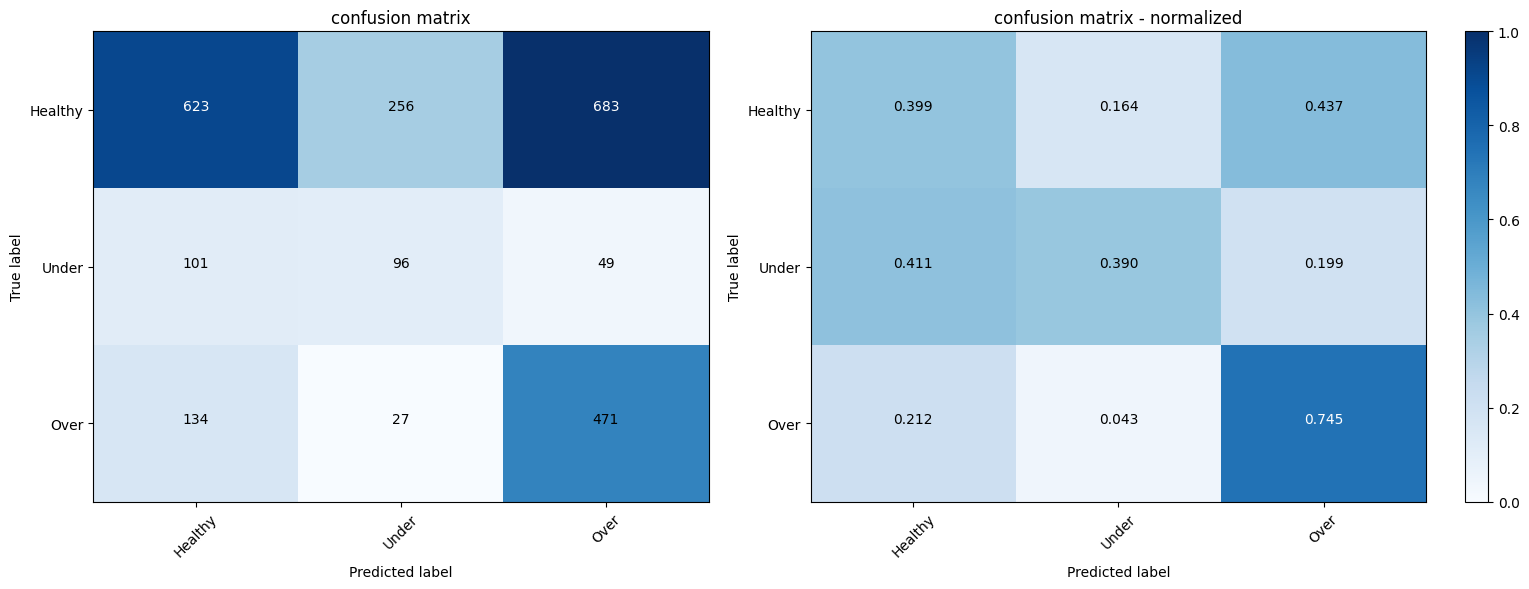

In [59]:
print(classification_report(df_out['gt'], df_out['pred'] ))
class_names = ['Healthy', 'Under', 'Over']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_out['gt'], df_out['pred'])
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')